# Book Recommender System with Keras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
books_df = pd.read_csv('books_enriched.csv')
books_ratings = pd.read_csv('ratings.csv')
books_ratings.drop_duplicates(inplace=True)
print('we have', books_ratings.shape[0], 'ratings')
books_ratings.head()

we have 5976479 ratings


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [3]:
books_df.head()

,Unnamed: 0,index,authors,average_rating,best_book_id,book_id,books_count,description,genres,goodreads_book_id,...,ratings_3,ratings_4,ratings_5,ratings_count,small_image_url,title,work_id,work_ratings_count,work_text_reviews_count,authors_2
0,0,0,['Suzanne Collins'],4.34,2767052,1,272,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,"['young-adult', 'fiction', 'fantasy', 'science...",2767052,...,560092,1481305,2706317,4780653,https://images.gr-assets.com/books/1447303603s...,"The Hunger Games (The Hunger Games, #1)",2792775,4942365,155254,['Suzanne Collins']
1,1,1,"['J.K. Rowling', 'Mary GrandPré']",4.44,3,2,491,Harry Potter's life is miserable. His parents ...,"['fantasy', 'fiction', 'young-adult', 'classics']",3,...,455024,1156318,3011543,4602479,https://images.gr-assets.com/books/1474154022s...,Harry Potter and the Sorcerer's Stone (Harry P...,4640799,4800065,75867,"['J.K. Rowling', 'Mary GrandPré']"
2,2,2,['Stephenie Meyer'],3.57,41865,3,226,About three things I was absolutely positive.\...,"['young-adult', 'fantasy', 'romance', 'fiction...",41865,...,793319,875073,1355439,3866839,https://images.gr-assets.com/books/1361039443s...,"Twilight (Twilight, #1)",3212258,3916824,95009,['Stephenie Meyer']
3,3,3,['Harper Lee'],4.25,2657,4,487,The unforgettable novel of a childhood in a sl...,"['classics', 'fiction', 'historical-fiction', ...",2657,...,446835,1001952,1714267,3198671,https://images.gr-assets.com/books/1361975680s...,To Kill a Mockingbird,3275794,3340896,72586,['Harper Lee']
4,4,4,['F. Scott Fitzgerald'],3.89,4671,5,1356,Alternate Cover Edition ISBN: 0743273567 (ISBN...,"['classics', 'fiction', 'historical-fiction', ...",4671,...,606158,936012,947718,2683664,https://images.gr-assets.com/books/1490528560s...,The Great Gatsby,245494,2773745,51992,['F. Scott Fitzgerald']


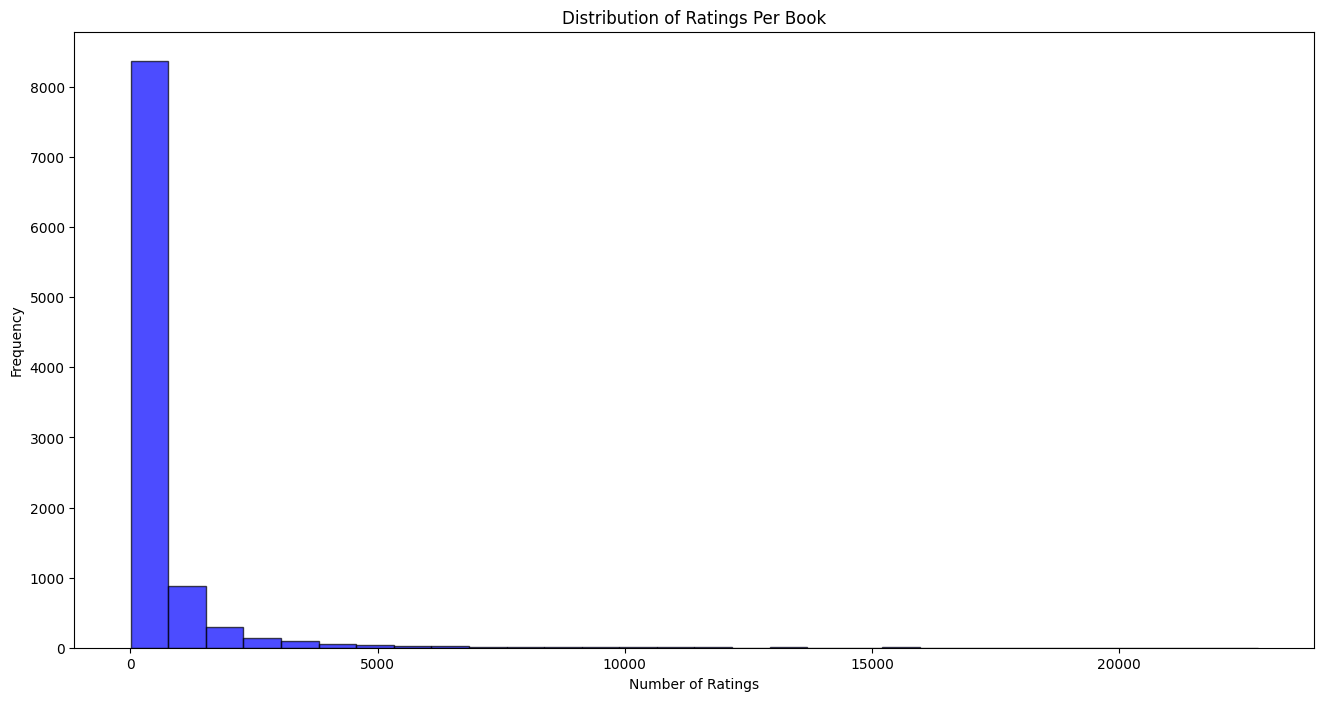

In [4]:
no_of_ratings_per_book = books_ratings.groupby('book_id').count()

# Set up the figure size
plt.figure(figsize=(16,8))

# Plot the histogram
plt.hist(no_of_ratings_per_book['rating'], bins=30, color='blue', edgecolor='black', alpha=0.7)

# Adding labels and title for clarity
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings Per Book')

# Show the plot
plt.show()

**The user_id and book_id in the dataset are currently non-sequential, it is required to convert them into sequential (starting from 0). Scikit-learn's LabelEncoder class helps to transform the fields.**

In [7]:
#user
user_enc = LabelEncoder()
books_ratings['user'] = user_enc.fit_transform(books_ratings['user_id'].values)
n_users = books_ratings['user'].nunique()

#book
item_enc = LabelEncoder()
books_ratings['book'] = item_enc.fit_transform(books_ratings['book_id'].values)
n_books = books_ratings['book'].nunique()

books_ratings['rating'] = books_ratings['rating'].values.astype(np.float32)

min_rating = min(books_ratings['rating'])
max_rating = max(books_ratings['rating'])

print('the number of unique users we have is ', n_users)
print('the number of unique books we have is ', n_books)
print('The median user rated %d books.'%books_ratings.user_id.value_counts().median())
print('The max rating is: %d'%max_rating, "the min rating is: %d"%min_rating)
books_ratings.tail()

the number of unique users we have is  53424
the number of unique books we have is  10000
The median user rated 111 books.
The max rating is: 5 the min rating is: 1


,user_id,book_id,rating,user,book
5976474,49925,510,5.0,49924,509
5976475,49925,528,4.0,49924,527
5976476,49925,722,4.0,49924,721
5976477,49925,949,5.0,49924,948
5976478,49925,1023,4.0,49924,1022


**Split into training and test sets, with an 80-20 split.**

In [9]:
X = books_ratings[['user', 'book']].values
y = books_ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4781183, 2), (1195296, 2), (4781183,), (1195296,))

In [12]:
n_factors = 20 # Number of factors per user/book (hyperparameter)
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

**Define the model**

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [25]:
def RecommenderNet(n_users, n_books, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal', 
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)

    book = Input(shape=(1,))
    m = Embedding(n_books, n_factors, embeddings_initializer='he_normal', 
                 embeddings_regularizer=l2(1e-6))(book)
    m = Reshape((n_factors,))(m)

    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, book], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [26]:
model = RecommenderNet(n_users, n_books, n_factors)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 20)     │  1,068,480 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 20)     │    200,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 20)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 20)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ reshape_2[0][0],  │
│                     │                   │            │ reshape_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,268,480 (4.84 MB)

 Trainable params: 1,268,480 (4.84 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5, 
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
74706/74706 ━━━━━━━━━━━━━━━━━━━━ 348s 5ms/step - loss: 6.2476 - val_loss: 1.0601
Epoch 2/5
74706/74706 ━━━━━━━━━━━━━━━━━━━━ 357s 5ms/step - loss: 1.0438 - val_loss: 1.0316
Epoch 3/5
74706/74706 ━━━━━━━━━━━━━━━━━━━━ 477s 6ms/step - loss: 1.0075 - val_loss: 1.0115
Epoch 4/5
74706/74706 ━━━━━━━━━━━━━━━━━━━━ 372s 5ms/step - loss: 0.9789 - val_loss: 1.0015
Epoch 5/5
74706/74706 ━━━━━━━━━━━━━━━━━━━━ 391s 5ms/step - loss: 0.9570 - val_loss: 0.9940


**Taking a look at the model performance, it has performed well. More epoh would only cause the model to overfit.**

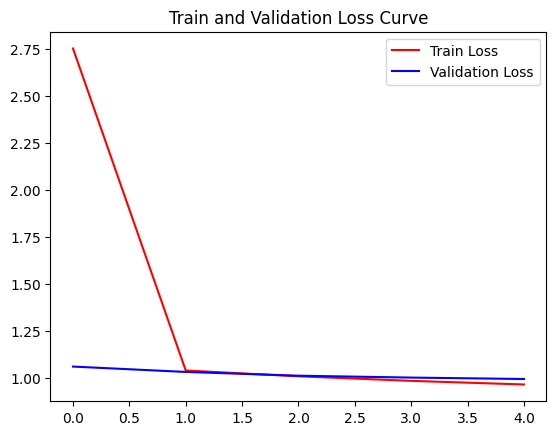

In [28]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

**The embedding layer can be extracted and visalised.**

In [30]:
book_em = model.get_layer('embedding_2')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(53424, 20)

In [31]:
from sklearn.decomposition import PCA

In [32]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_em_weights)

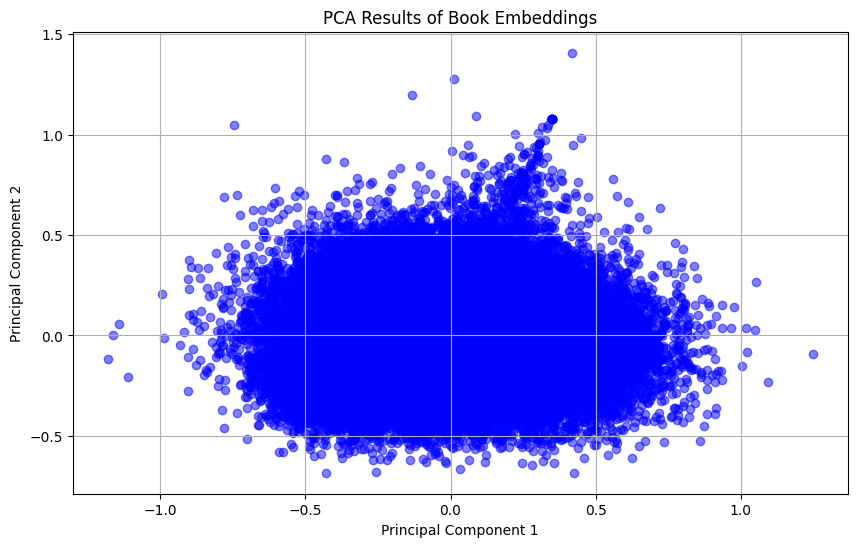

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5, color='blue')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Results of Book Embeddings')
plt.grid(True) 
plt.show()

# Making Recommendations

**We can use the model to predict the top 10 recommendations for a user**

In [34]:
print(books_ratings[books_ratings['user_id'] == 8000])

         user_id  book_id  rating  user  book
768617      8000     1672     4.0  7999  1671
768618      8000     2649     4.0  7999  2648
785746      8000      529     4.0  7999   528
785747      8000      959     3.0  7999   958
830674      8000      236     4.0  7999   235
...          ...      ...     ...   ...   ...
5356143     8000     1625     2.0  7999  1624
5637350     8000     1332     4.0  7999  1331
5708521     8000     2253     4.0  7999  2252
5734145     8000     2052     5.0  7999  2051
5767170     8000     2676     4.0  7999  2675

[95 rows x 5 columns]


In [35]:
#Making recommendations for user 8000
user_r = 8000
b_id = list(books_ratings.book_id.unique())
book_arr = np.array(b_id) # get all book IDs
user = np.array([user_r for i in range(len(b_id))])
pred = model.predict([book_arr, user])
pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


array([[4.091794 ],
       [3.515154 ],
       [3.74977  ],
       ...,
       [2.8855538],
       [4.86559  ],
       [2.3354425]], dtype=float32)

In [36]:
pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:10]
pred_ids

array([4407, 9648, 9038, 8120, 3994, 8533, 3255, 9957, 5150,  635])

In [37]:
top10 = books_df.iloc[pred_ids]
f=['title','small_image_url']
displ=(top10[f])
displ.set_index('title', inplace=True)

In [38]:
from IPython.display import Image, HTML

def path_to_image_html(path):
    return '<img src="'+ path + '""/>'

HTML(displ.to_html(escape=False ,formatters=dict(small_image_url=path_to_image_html),justify='center'))

,small_image_url
title,
Katherine,
The Girl You Lost,
"Moonlight Mile (Kenzie & Gennaro,#6)",
Bread and Wine: A Love Letter to Life Around the Table with Recipes,
Until I Find You,
Anatomy of the Spirit: The Seven Stages of Power and Healing,
"Fear Nothing (Moonlight Bay, #1)",
"Mummies in the Morning (Magic Tree House, #3)",
Arsenic and Old Lace,


In [41]:
from sklearn.metrics import mean_squared_error
from math import sqrt
predicted_ratings = model.predict(X_test_array)

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, predicted_ratings))
print(f"Root Mean Squared Error: {rmse}")

37353/37353 ━━━━━━━━━━━━━━━━━━━━ 8s 215us/step
Root Mean Squared Error: 0.8934627965152586
